Check running TensorFlow version

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

# Sentiment movie reviews classification

This is a binary classification problem (2 classes, negative and positive). 

The dataset I will use is [IMDB reviews](https://ai.stanford.edu/~amaas/data/sentiment/), it contains a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.

I will use a basic dense model to start with and find out how well it performs on this dataset. 1D conv, LSTM, GRU, Bidirectional are stuff I can try later.

In [2]:
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import matplotlib.pyplot as plt
%matplotlib inline

import random as rand

import numpy as np

import shutil

In [3]:
batch_size = 256

## Load IMDB review and get familiar with it

In [4]:
vocab_size = 10000
(train_x, train_y), (test_x, test_y) = datasets.imdb.load_data(num_words=vocab_size)

In [5]:
train_x.shape, train_y.shape

((25000,), (25000,))

In [6]:
test_x.shape, test_y.shape

((25000,), (25000,))

Load the word index dictionary and reverse a few triaing strings

Note: the indices are offset by 3 because 0, 1, and 2 are reserved indices for "padding", "start of sequence", and "unknown".

In [7]:
word_index = datasets.imdb.get_word_index()
word_index = {key: (value + 3) for key, value in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

word_index_reversed = {value: key for key, value in word_index.items()}

In [8]:
translate_sentence = lambda sentence : " ".join([word_index_reversed.get(word, '?') for word in sentence])

In [9]:
random_indecies = rand.choices(list(range(train_x.shape[0])), k=1)

for index in random_indecies:
    sentence = translate_sentence(train_x[index][1:])
    print(sentence, end="\n\n")

a fascinating look at the relationship of a single father in 1998 and a single mother in <UNK> tied together by a time traveling teenager reminded me of somewhere in time richard <UNK> <UNK> time return as rendered by christopher reeves and jane seymour



## Pad the training and test data

Because of input data is of different sizes, I will set a max length limit on them or pad them if their length was shorter than max length

In [10]:
max_length = 200

# Default :: , padding='pre', truncating='pre'
train_x = pad_sequences(train_x, maxlen=max_length)
test_x = pad_sequences(test_x, maxlen=max_length)

In [11]:
train_x.shape, test_x.shape

((25000, 200), (25000, 200))

## Build the model

In [42]:
embedding_size = 100
model = Sequential()

embedding_layer = layers.Embedding(vocab_size, embedding_size, input_length=max_length)
model.add(embedding_layer)

# model.add(layers.GlobalAveragePooling1D())  # Performed better than using Flatten layer in the previous experiment.
# model.add(layers.Dense(16, activation='relu'))

model.add(layers.LSTM(32)) # Performed a little better than Dense, no surprise here

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


## Download GloVe pre-trainined word vectors

Here I will use the smallest available pre-trained word vectors from [GloVe](https://nlp.stanford.edu/projects/glove/) which should be more than enough. That was glove.6B.zip which consists of 6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors. It is an 822 MB download.

In [13]:
embedding_path = Path("../embedding")
embedding_path.mkdir(parents=True, exist_ok=True)

In [ ]:
!wget -O {embedding_path}/glove.6B.zip http://nlp.stanford.edu/data/glove.6B.zip

In [14]:
!ls {embedding_path}

glove.6B.100d.txt


In [ ]:
!unzip {embedding_path}/glove.6B.zip -d {embedding_path}

In [15]:
embedding_layer.embeddings.shape

TensorShape([10000, 100])

In [16]:
embedding_layer.input_shape, embedding_layer.output_shape  # max_length, embedding_size

((None, 200), (None, 200, 100))

In [17]:
embedding_index = {}

with open(embedding_path/"glove.6B.100d.txt", "r") as reader:
    line = reader.readline()
    while line != '':  # The EOF char is an empty string
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], np.float32)
        embedding_index[word] = coefs
        
        line = reader.readline()

len(embedding_index)

400000

In [18]:
print(f"Corpus total vocab size is {len(word_index.items())} vs. {len(embedding_index)} in glove.6B")

Corpus total vocab size is 88588 vs. 400000 in glove.6B


`word_index` consist of the word mapping to its index

In [19]:
embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in word_index.items():
    if index >= vocab_size:
        continue
    
    coefs = embedding_index.get(word)
    if coefs is not None:
        embedding_matrix[index] = coefs
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.55689001,  0.33454001,  0.068255  , ...,  0.037454  ,
        -0.52304   ,  0.52328998],
       [ 0.045259  ,  0.31463999,  0.64099002, ..., -0.1689    ,
        -1.05400002,  0.47262999],
       [ 0.39943001,  0.54632998,  0.38009   , ...,  0.45795   ,
        -0.18339001,  0.12257   ]])

## Set the embedding layer weights

In [43]:
embedding_layer.set_weights([embedding_matrix])
embedding_layer.trainable = False

## Train

In [44]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Make sure we are not training the embedding layer.
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 17,057
Non-trainable params: 1,000,000
_________________________________________________________________


In [45]:
history = model.fit(x=train_x, y=train_y, validation_split=0.2, shuffle=True, batch_size=batch_size, epochs=10)
history.history.keys()

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.6458 - accuracy: 0.6205 - val_loss: 0.5686 - val_accuracy: 0.7176
Epoch 2/10
20000/20000 [==============================] - 18s 902us/sample - loss: 0.5799 - accuracy: 0.6990 - val_loss: 0.6280 - val_accuracy: 0.6498
Epoch 3/10
20000/20000 [==============================] - 18s 885us/sample - loss: 0.5407 - accuracy: 0.7316 - val_loss: 0.5562 - val_accuracy: 0.7092
Epoch 4/10
20000/20000 [==============================] - 18s 879us/sample - loss: 0.5094 - accuracy: 0.7548 - val_loss: 0.4826 - val_accuracy: 0.7708
Epoch 5/10
20000/20000 [==============================] - 15s 726us/sample - loss: 0.4845 - accuracy: 0.7739 - val_loss: 0.4981 - val_accuracy: 0.7588
Epoch 6/10
20000/20000 [==============================] - 14s 698us/sample - loss: 0.4620 - accuracy: 0.7850 - val_loss: 0.4709 - val_accuracy: 0.7718
Epoch 7/10
20000/20000 [=======================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

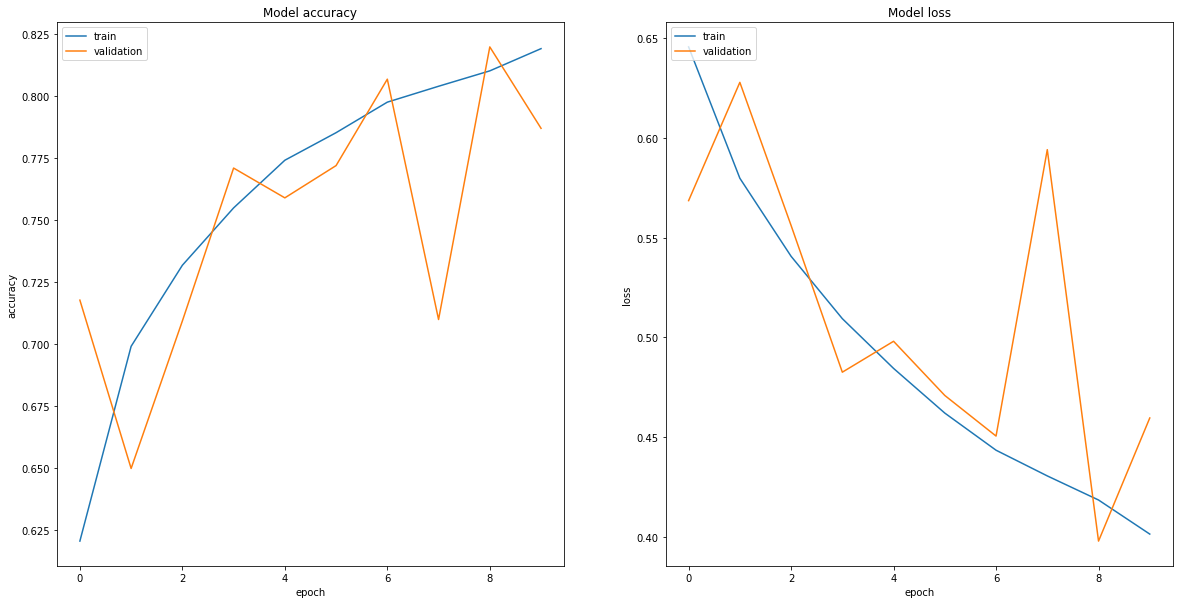

In [46]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Evaluate

In [47]:
loss, accuracy = model.evaluate(x=test_x, y=test_y)
loss, accuracy

25000/25000 [==============================] - 23s 929us/sample - loss: 0.4541 - accuracy: 0.7910


(0.45413335730552673, 0.791)

## Predict on one sentence

In [ ]:
model.trainable = False

# Compile model so changes to trainable would take effect
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
sentence

In [ ]:
index = 0

sentence = test_x[index]
translate_sentence(sentence), test_y[index]

In [ ]:
sentence = sentence.reshape(1, *sentence.shape)
sentence.shape

In [ ]:
output = model(sentence)
float(output)